In [1]:
import pandas as pd

# Load the data from the provided Excel file
file_path = 'SMM921_pf_data_2024.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the data from the first sheet
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Convert the Date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Calculate monthly returns for each country
returns = data.set_index('Date').pct_change().dropna()

# Calculate the 'world stock market return' as the average return across the 34 countries
returns['World'] = returns.mean(axis=1)

# Compute mean returns, return standard deviations and Sharpe ratios (all annualised) for each country
annual_factor = 12
mean_returns = returns.mean() * annual_factor
std_devs = returns.std() * (annual_factor**0.5)
risk_free_rate = 0.02  # Assume a risk-free rate of 2%
sharpe_ratios = (mean_returns - risk_free_rate) / std_devs

# Create a DataFrame to store the computed metrics
metrics = pd.DataFrame({
    'Mean Return': mean_returns,
    'Standard Deviation': std_devs,
    'Sharpe Ratio': sharpe_ratios
})

# Display the computed metrics
print(metrics)

# Optional: Save the metrics to a CSV file
metrics.to_csv('country_metrics.csv', index=True)

from IPython.display import display

# Display the computed metrics
display(metrics)


              Mean Return  Standard Deviation  Sharpe Ratio
USA              0.112424            0.154444      0.598429
UK               0.071022            0.187298      0.272410
SWITZERLAND      0.096678            0.160707      0.477127
JAPAN            0.068923            0.173699      0.281654
CANADA           0.102469            0.201588      0.409095
AUSTRALIA        0.112316            0.225111      0.410090
NEW ZEALAND      0.089323            0.207781      0.333636
SWEDEN           0.113501            0.225007      0.415549
NORWAY           0.106580            0.257089      0.336772
DENMARK          0.161227            0.203060      0.695491
GERMANY          0.096837            0.224210      0.342700
ITALY            0.079215            0.261504      0.226439
FRANCE           0.096873            0.216393      0.355246
NETHERLANDS      0.121113            0.224690      0.450012
BELGIUM          0.069622            0.235503      0.210708
FINLAND          0.085793            0.2

,Mean Return,Standard Deviation,Sharpe Ratio
USA,0.112424,0.154444,0.598429
UK,0.071022,0.187298,0.272410
SWITZERLAND,0.096678,0.160707,0.477127
JAPAN,0.068923,0.173699,0.281654
CANADA,0.102469,0.201588,0.409095
AUSTRALIA,0.112316,0.225111,0.410090
NEW ZEALAND,0.089323,0.207781,0.333636
SWEDEN,0.113501,0.225007,0.415549
NORWAY,0.106580,0.257089,0.336772
DENMARK,0.161227,0.203060,0.695491


C:\Users\ericw\AppData\Local\Temp\ipykernel_1908\1060979616.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (metrics['Standard Deviation'][i], metrics['Mean Return'][i]),


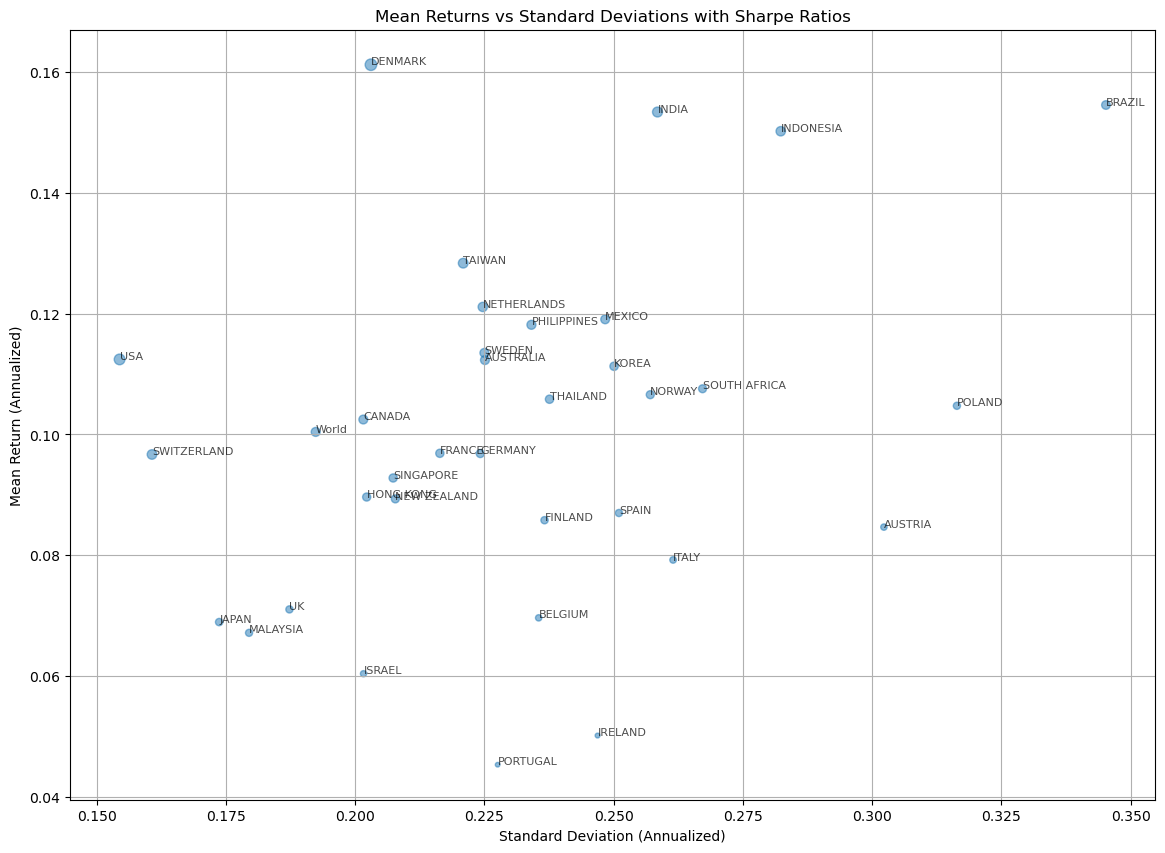

In [2]:
import matplotlib.pyplot as plt

# Plot Mean Returns vs Standard Deviations with Sharpe Ratios as bubble sizes
plt.figure(figsize=(14, 10))

# Scatter plot
plt.scatter(metrics['Standard Deviation'], metrics['Mean Return'], 
            s=metrics['Sharpe Ratio'] * 100, alpha=0.5)

# Adding titles and labels
for i, txt in enumerate(metrics.index):
    plt.annotate(txt, (metrics['Standard Deviation'][i], metrics['Mean Return'][i]),
                 fontsize=8, alpha=0.7)
plt.title('Mean Returns vs Standard Deviations with Sharpe Ratios')
plt.xlabel('Standard Deviation (Annualized)')
plt.ylabel('Mean Return (Annualized)')
plt.grid(True)

# Display the plot
plt.show()

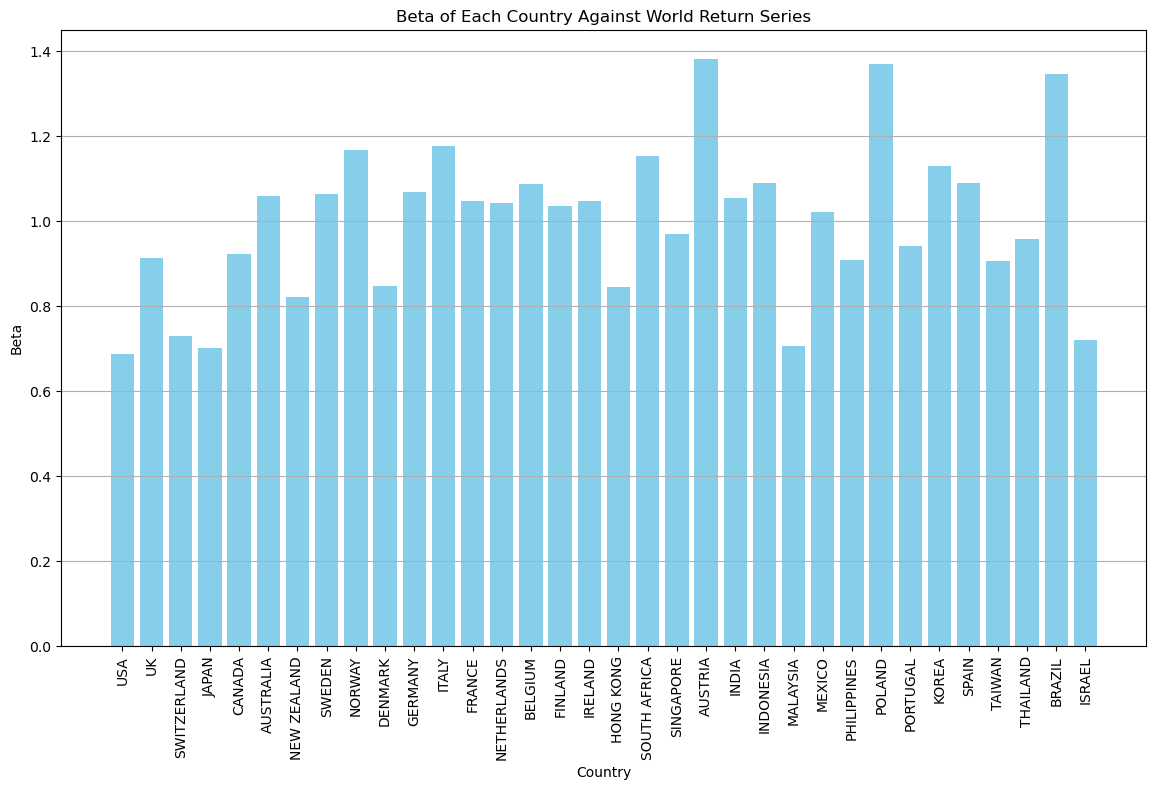

In [3]:
import numpy as np
import statsmodels.api as sm

# Calculate the beta for each country against the world return series
betas = {}
world_returns = returns['World']

for country in returns.columns[:-1]:  # Exclude 'World' from the countries list
    country_returns = returns[country]
    X = sm.add_constant(world_returns)  # Add a constant term for the intercept
    model = sm.OLS(country_returns, X).fit()
    betas[country] = model.params['World']

# Create a DataFrame for betas
betas_df = pd.DataFrame(list(betas.items()), columns=['Country', 'Beta'])

# Plot the betas
plt.figure(figsize=(14, 8))
plt.bar(betas_df['Country'], betas_df['Beta'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Beta')
plt.title('Beta of Each Country Against World Return Series')
plt.grid(axis='y')
plt.show()

In [4]:
# Calculate the momentum signal for each country
momentum_signals = pd.DataFrame(index=returns.index, columns=returns.columns[:-1])  # Exclude 'World'

for country in momentum_signals.columns:
    # Calculate the cumulative return over the past 12 months, excluding the most recent month
    momentum_signals[country] = (1 + returns[country]).rolling(window=12).apply(
        lambda x: np.prod(x[:-1]) if len(x) == 12 else np.nan).shift(1)

# Display the first few rows of the momentum signals DataFrame
print(momentum_signals.head())

# Display the last few rows of the momentum signals DataFrame to verify calculations beyond initial NaN periods
print(momentum_signals.tail(15))

            USA  UK  SWITZERLAND  JAPAN  CANADA  AUSTRALIA  NEW ZEALAND  \
Date                                                                      
2004-06-17  NaN NaN          NaN    NaN     NaN        NaN          NaN   
2004-07-17  NaN NaN          NaN    NaN     NaN        NaN          NaN   
2004-08-17  NaN NaN          NaN    NaN     NaN        NaN          NaN   
2004-09-17  NaN NaN          NaN    NaN     NaN        NaN          NaN   
2004-10-17  NaN NaN          NaN    NaN     NaN        NaN          NaN   

            SWEDEN  NORWAY  DENMARK  ...  MEXICO  PHILIPPINES  POLAND  \
Date                                 ...                                
2004-06-17     NaN     NaN      NaN  ...     NaN          NaN     NaN   
2004-07-17     NaN     NaN      NaN  ...     NaN          NaN     NaN   
2004-08-17     NaN     NaN      NaN  ...     NaN          NaN     NaN   
2004-09-17     NaN     NaN      NaN  ...     NaN          NaN     NaN   
2004-10-17     NaN     NaN      NaN 

In [5]:
for country in momentum_signals.columns:
    # Calculate the cumulative return over the past 12 months, excluding the most recent month
    momentum_signals[country] = (1 + returns[country]).rolling(window=12).apply(
        lambda x: np.prod(x[:-1]) if len(x) == 12 else np.nan).shift(1)

# Function to assign countries to momentum-sorted portfolios
def assign_to_portfolios(momentum):
    ranks = momentum.rank()
    quintiles = pd.qcut(ranks, 5, labels=False)
    return quintiles

# DataFrame to store portfolio returns
portfolio_returns = pd.DataFrame(index=returns.index, columns=['P1', 'P2', 'P3', 'P4', 'P5'])

# Calculate returns for the portfolios
for date in momentum_signals.index[12:]:
    # Get momentum signals for the current month
    current_momentum = momentum_signals.loc[date]
    
    # Assign countries to portfolios based on momentum
    portfolios = assign_to_portfolios(current_momentum)
    
    # Calculate returns for each portfolio in the subsequent month
    next_month = date + pd.DateOffset(months=1)
    if next_month in returns.index:
        for quintile in range(5):
            portfolio_countries = portfolios[portfolios == quintile].index
            portfolio_returns.loc[next_month, f'P{quintile + 1}'] = returns.loc[next_month, portfolio_countries].mean()

# Drop NaN values that could exist due to initial periods
portfolio_returns = portfolio_returns.dropna()

# Display the first few rows of the portfolio returns DataFrame
print(portfolio_returns.head())

# Display the last few rows of the portfolio returns DataFrame
print(portfolio_returns.tail())

                  P1        P2        P3        P4        P5
Date                                                        
2005-07-17 -0.002855  0.014695  0.012565 -0.001561  0.015058
2005-08-17  0.041861  0.032053   0.04442  0.046578  0.069969
2005-09-17  0.013274  0.023086 -0.002405  0.044988  0.048189
2005-10-17 -0.008356 -0.015566 -0.032552  -0.04337 -0.025573
2005-11-17  0.006284  0.020962  0.007148  0.005748  0.047042
                  P1        P2        P3        P4        P5
Date                                                        
2024-01-17 -0.039871 -0.008681 -0.039963 -0.017722 -0.013395
2024-02-17  0.027721  0.015872  0.046311  0.085214  0.042179
2024-03-17  0.011971  0.004556   0.03391  0.032488  0.032119
2024-04-17 -0.028213 -0.030945 -0.030071 -0.029119 -0.024459
2024-05-17   0.12377  0.064224  0.090342  0.059425  0.071371


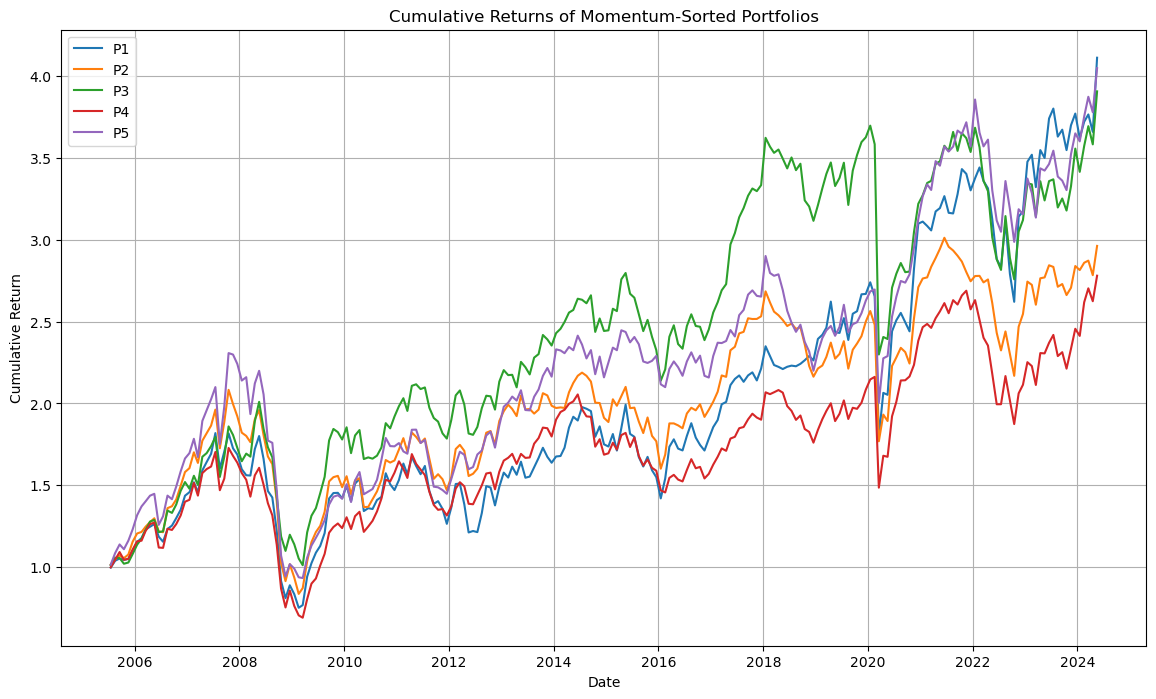

,Mean Return,Standard Deviation,Sharpe Ratio
P1,0.100861,0.224747,0.359788
P2,0.077941,0.198632,0.2917
P3,0.092506,0.19638,0.369212
P4,0.07497,0.199734,0.275217
P5,0.094713,0.198787,0.375846


In [6]:
# Calculate mean return, volatility, and Sharpe ratio for each portfolio (all annualised)
annual_factor = 12
risk_free_rate = 0.02  # Assume a risk-free rate of 2%

portfolio_metrics = pd.DataFrame(index=portfolio_returns.columns, columns=['Mean Return', 'Standard Deviation', 'Sharpe Ratio'])

for portfolio in portfolio_returns.columns:
    mean_return = portfolio_returns[portfolio].mean() * annual_factor
    std_dev = portfolio_returns[portfolio].std() * (annual_factor**0.5)
    sharpe_ratio = (mean_return - risk_free_rate) / std_dev
    
    portfolio_metrics.loc[portfolio] = [mean_return, std_dev, sharpe_ratio]

# Calculate cumulative returns for each portfolio
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns for each portfolio
plt.figure(figsize=(14, 8))

for portfolio in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[portfolio], label=portfolio)

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns of Momentum-Sorted Portfolios')
plt.legend()
plt.grid(True)
plt.show()

# Display the portfolio metrics
portfolio_metrics

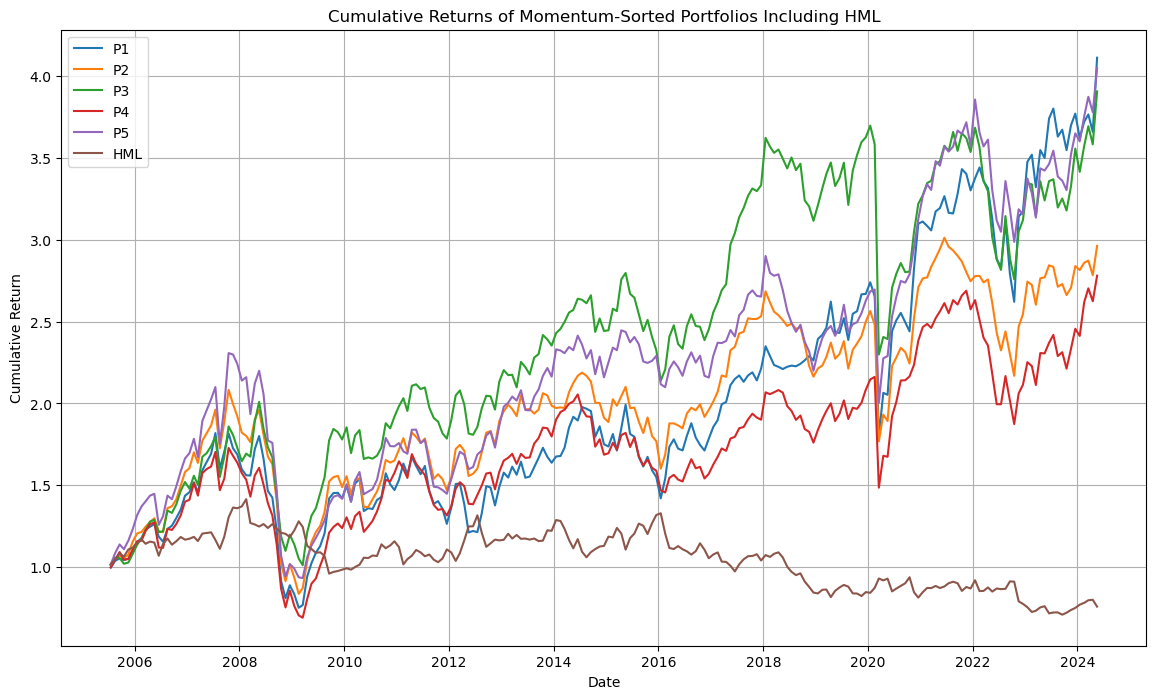

,Mean Return,Standard Deviation,Sharpe Ratio
P1,0.100861,0.224747,0.359788
P2,0.077941,0.198632,0.2917
P3,0.092506,0.19638,0.369212
P4,0.07497,0.199734,0.275217
P5,0.094713,0.198787,0.375846
HML,-0.006148,0.129246,-0.202312


In [7]:
# Calculate the HML portfolio returns (High-minus-Low)
portfolio_returns['HML'] = portfolio_returns['P5'] - portfolio_returns['P1']

# Calculate mean return, volatility, and Sharpe ratio for the HML portfolio (all annualised)
mean_return_hml = portfolio_returns['HML'].mean() * annual_factor
std_dev_hml = portfolio_returns['HML'].std() * (annual_factor**0.5)
sharpe_ratio_hml = (mean_return_hml - risk_free_rate) / std_dev_hml

# Add HML metrics to the portfolio_metrics DataFrame
hml_metrics = pd.DataFrame({
    'Mean Return': [mean_return_hml],
    'Standard Deviation': [std_dev_hml],
    'Sharpe Ratio': [sharpe_ratio_hml]
}, index=['HML'])

portfolio_metrics = pd.concat([portfolio_metrics, hml_metrics])

# Calculate cumulative returns for the HML portfolio
cumulative_returns['HML'] = (1 + portfolio_returns['HML']).cumprod()

# Plot cumulative returns for each portfolio including HML
plt.figure(figsize=(14, 8))

for portfolio in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[portfolio], label=portfolio)

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns of Momentum-Sorted Portfolios Including HML')
plt.legend()
plt.grid(True)
plt.show()

# Display the updated portfolio metrics including HML
portfolio_metrics